##PJM Regional Electric Consumption Forecasting Project

In [1]:
# (empezar de nuevo: primero import the libraries that Iam using)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Statistical
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


# M.L
from sklearn.metrics import mean_absolute_error, mean_squared_error


# conectar con google drive
from google.colab import drive
# Plotting style
plt.style.use('default')

 1. Data Loading - Simple Google Drive Mount

In [2]:
drive.mount('/content/drive')

# Load la data
file_path = '/content/drive/MyDrive/MachineLearningAvanzado/sumsion2/AEP_hourly.csv'
df = pd.read_csv(file_path)

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df = df.sort_index()

#information
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Columns: {list(df.columns)}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (121273, 1)
Date range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Missing values: 0
Columns: ['AEP_MW']


2. Feature Engineering

In [3]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_features = df.copy()
    df_features['date'] = df_features.index
    df_features['hour'] = df_features['date'].dt.hour
    df_features['dayofweek'] = df_features['date'].dt.dayofweek
    df_features['quarter'] = df_features['date'].dt.quarter
    df_features['month'] = df_features['date'].dt.month
    df_features['year'] = df_features['date'].dt.year
    df_features['dayofyear'] = df_features['date'].dt.dayofyear
    df_features['dayofmonth'] = df_features['date'].dt.day
    df_features['weekofyear'] = df_features['date'].dt.isocalendar().week

    X = df_features[['hour','dayofweek','quarter','month','year',
                    'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_features[label]
        return X, y
    return X

# Apply feature engineering
X_features, y_target = create_features(df, label='AEP_MW')


 3. Exploratory Data Analysis


=== Exploratory Data Analysis ===


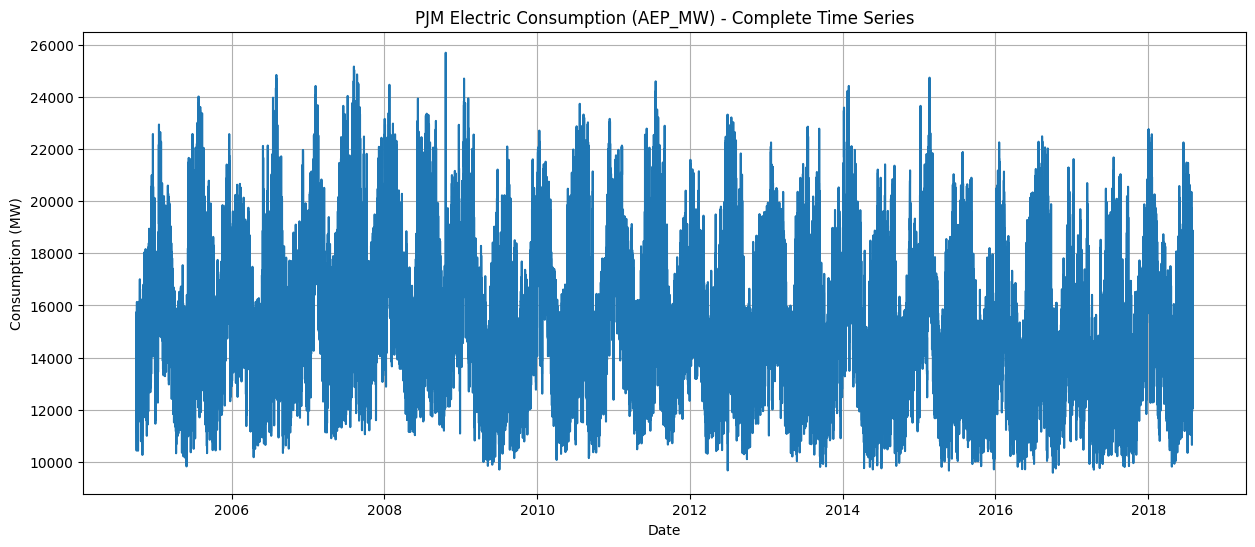

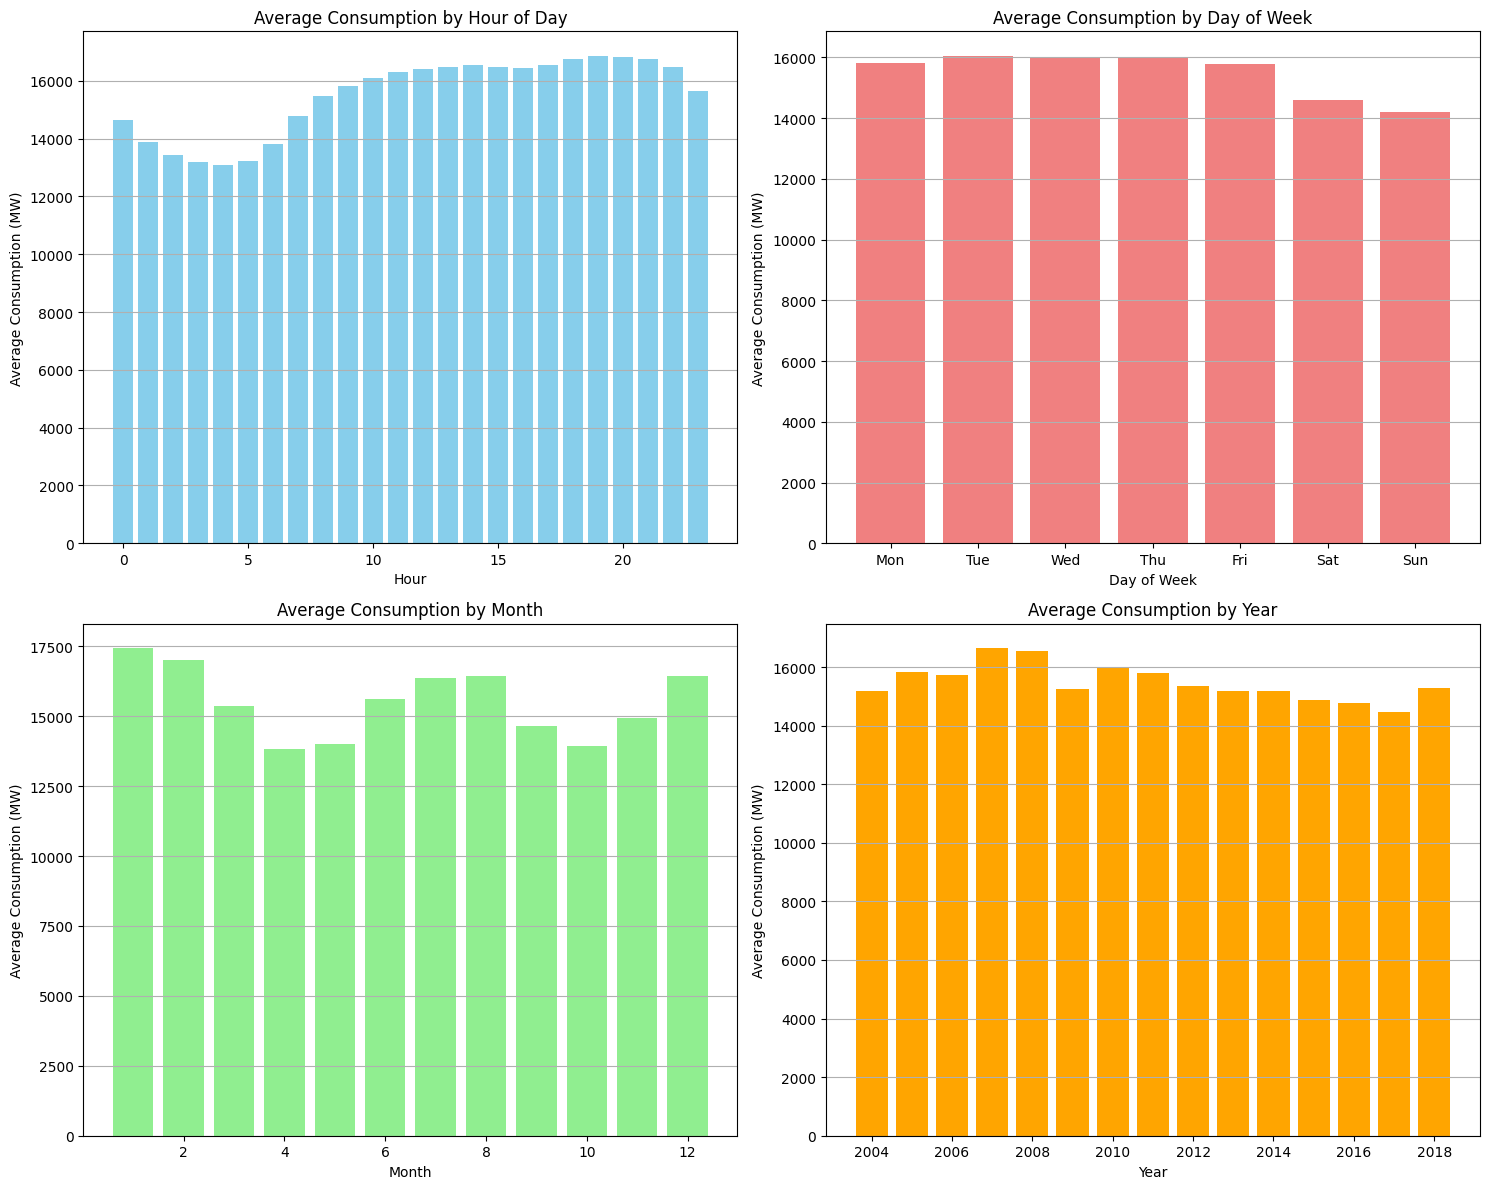

Identified Patterns:
- Peak consumption hour: 19 (16868.73 MW)
- Minimum consumption hour: 4 (13095.19 MW)
- Highest consumption day of week: Tue (16057.62 MW)
- Peak consumption month: 1 (17431.27 MW)


In [4]:
print("\n=== Exploratory Data Analysis ===")

# Plot complete data of time series
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['AEP_MW'])
plt.title('PJM Electric Consumption (AEP_MW) - Complete Time Series')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.grid(True)
plt.show()

# analysis: Seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# HOURS COLOR CIELO
hourly_avg = df.groupby(df.index.hour)['AEP_MW'].mean()
axes[0,0].bar(hourly_avg.index, hourly_avg.values, color='skyblue')
axes[0,0].set_title('Average Consumption by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Average Consumption (MW)')
axes[0,0].grid(True, axis='y')

# DAYS COLOR NARANJAROJO
dow_avg = df.groupby(df.index.dayofweek)['AEP_MW'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), dow_avg.values, color='lightcoral')
axes[0,1].set_title('Average Consumption by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Consumption (MW)')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(days)
axes[0,1].grid(True, axis='y')

# MONTH VERDEFOSFO
monthly_avg = df.groupby(df.index.month)['AEP_MW'].mean()
axes[1,0].bar(monthly_avg.index, monthly_avg.values, color='lightgreen')
axes[1,0].set_title('Average Consumption by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Consumption (MW)')
axes[1,0].grid(True, axis='y')

# YEAR NARANJA
yearly_avg = df.groupby(df.index.year)['AEP_MW'].mean()
axes[1,1].bar(yearly_avg.index, yearly_avg.values, color='orange')
axes[1,1].set_title('Average Consumption by Year')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Consumption (MW)')
axes[1,1].grid(True, axis='y')

plt.tight_layout()
plt.show()

# Print EVERYTHING
print("Identified Patterns:")
print(f"- Peak consumption hour: {hourly_avg.idxmax()} ({hourly_avg.max():.2f} MW)")
print(f"- Minimum consumption hour: {hourly_avg.idxmin()} ({hourly_avg.min():.2f} MW)")
print(f"- Highest consumption day of week: {days[dow_avg.idxmax()]} ({dow_avg.max():.2f} MW)")
print(f"- Peak consumption month: {monthly_avg.idxmax()} ({monthly_avg.max():.2f} MW)")


4. Time Series Decomposition


=== Time Series Decomposition ===


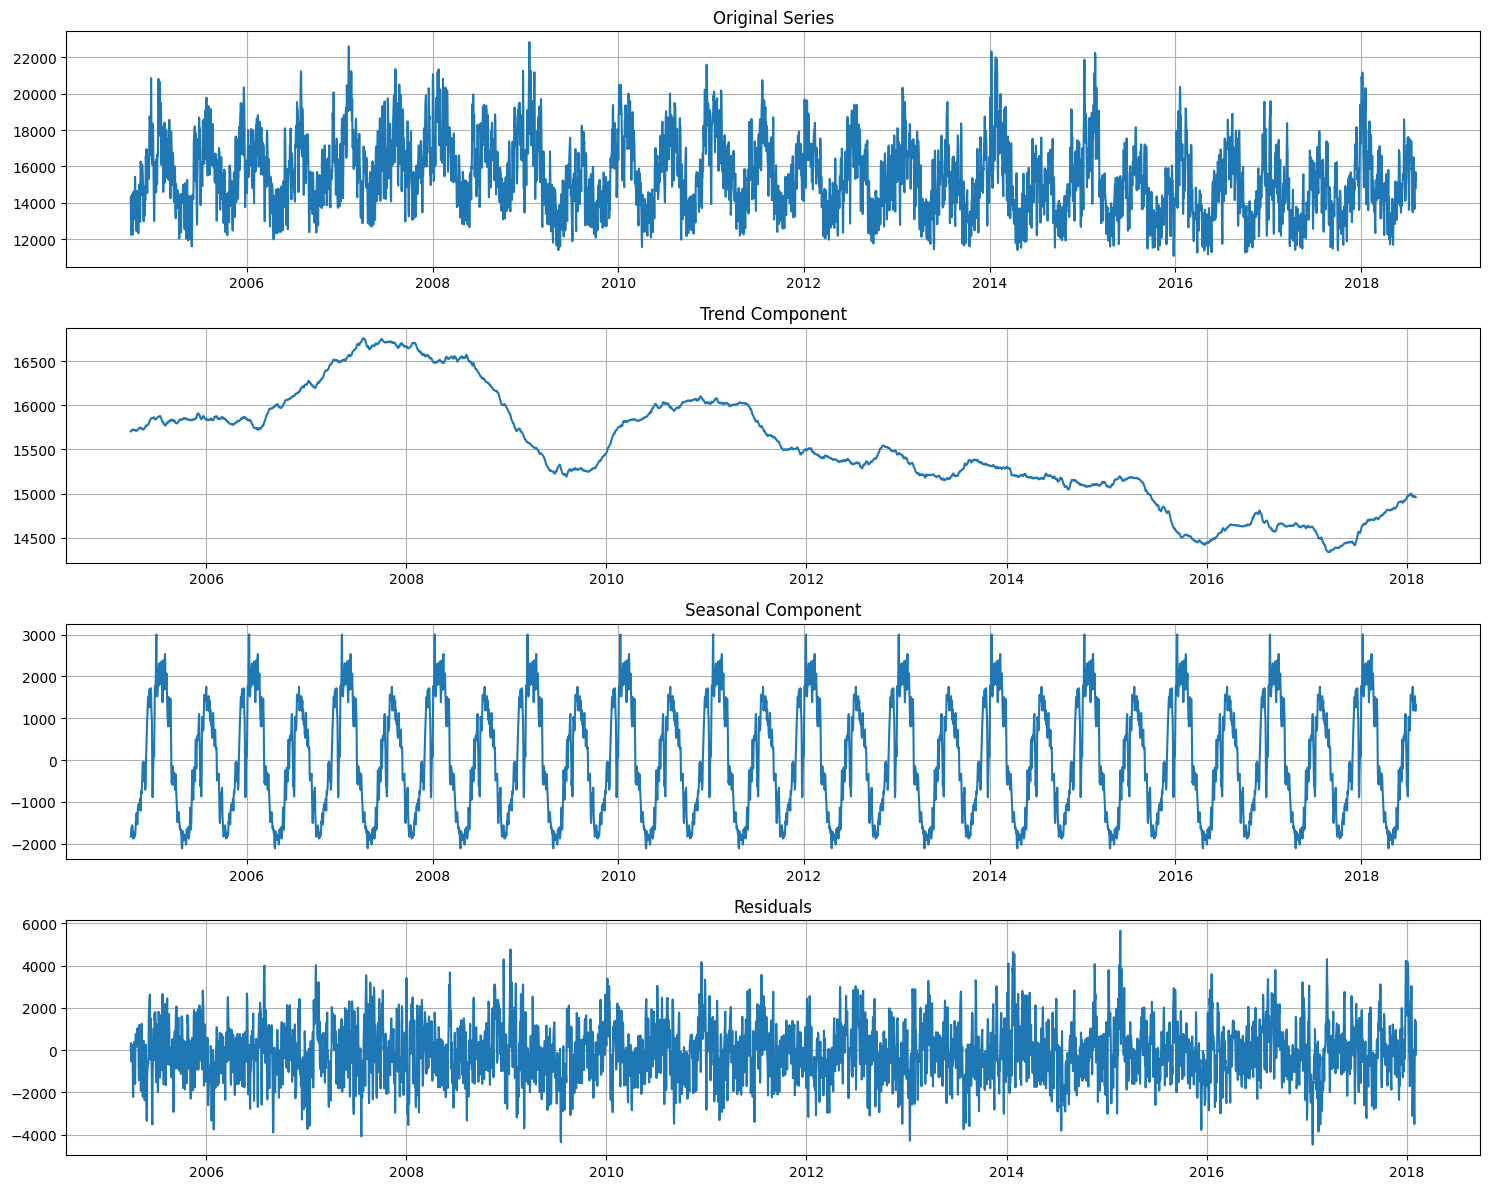

In [5]:
print("\n=== Time Series Decomposition ===")

# he utlizado el dayly to better visualization
df_daily = df.resample('D').mean()
result = seasonal_decompose(df_daily['AEP_MW'], model='additive', period=365)

# decomposition components
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(result.observed)
axes[0].set_title('Original Series')
axes[0].grid(True)

axes[1].plot(result.trend)
axes[1].set_title('Trend Component')
axes[1].grid(True)

axes[2].plot(result.seasonal)
axes[2].set_title('Seasonal Component')
axes[2].grid(True)

axes[3].plot(result.resid)
axes[3].set_title('Residuals')
axes[3].grid(True)
#resisual, seasonal, el tren y el original series, with this I can see the diferent descomposition
plt.tight_layout()
plt.show()

 5. Stationarity Testing (ADF) we need to know if the null hypotesis is reject or not

In [6]:
def test_stationarity(timeseries, title="Series"):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    print(f'\nStationarity Test Results for {title}:')
    print('-' * 50)

    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.6f}')

    if result[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is non-stationary (fail to reject null hypothesis)")

    return result[1] <= 0.05

# Test original series
is_stationary = test_stationarity(df['AEP_MW'], "Original AEP_MW Series")




Stationarity Test Results for Original AEP_MW Series:
--------------------------------------------------
ADF Statistic: -18.285884
p-value: 0.000000
Critical Values:
	1%: -3.430404
	5%: -2.861564
	10%: -2.566783
Series is stationary (reject null hypothesis)


 6. Train/Test Split

In [7]:
print("\n=== Data Splitting ===")

# Use last 30 days (720 hours) for testing
test_size = 30 * 24  # 30 days * 24 hours
split_index = len(df) - test_size

train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Testing period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

train_series = train_data['AEP_MW']
test_series = test_data['AEP_MW']


=== Data Splitting ===
Training period: 2004-10-01 01:00:00 to 2018-07-04 00:00:00
Testing period: 2018-07-04 01:00:00 to 2018-08-03 00:00:00
Training samples: 120553
Testing samples: 720


 7. Baseline Models Implementation

In [8]:
print("\n=== Baseline Models ===")

def calculate_metrics(actual, predicted):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Forecast horizon: 24 hours
forecast_horizon = 24
test_actual = test_series.iloc[:forecast_horizon]

# Baseline 1: Naive (last value)
naive_forecast = np.full(forecast_horizon, train_series.iloc[-1])
naive_metrics = calculate_metrics(test_actual, naive_forecast)

# Baseline 2: Seasonal Naive (24-hour lag)
seasonal_naive_forecast = train_series.iloc[-24:].values
seasonal_naive_metrics = calculate_metrics(test_actual, seasonal_naive_forecast)

# Baseline 3: Weekly Seasonal Naive (168-hour lag)
weekly_naive_forecast = train_series.iloc[-168:-168+24].values
weekly_naive_metrics = calculate_metrics(test_actual, weekly_naive_forecast)

# Baseline 4: Mean of training data
mean_forecast = np.full(forecast_horizon, train_series.mean())
mean_metrics = calculate_metrics(test_actual, mean_forecast)

# Store baseline results
baseline_results = {
    'Naive': naive_metrics,
    'Seasonal Naive (24h)': seasonal_naive_metrics,
    'Weekly Naive (168h)': weekly_naive_metrics,
    'Mean': mean_metrics
}

print("Baseline Model Results (24-hour forecast):")
for model, metrics in baseline_results.items():
    print(f"{model}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, MAPE={metrics['MAPE']:.2f}%")



=== Baseline Models ===
Baseline Model Results (24-hour forecast):
Naive: MAE=2510.00, RMSE=2776.23, MAPE=15.25%
Seasonal Naive (24h): MAE=803.71, RMSE=902.73, MAPE=4.76%
Weekly Naive (168h): MAE=1772.12, RMSE=1971.37, MAPE=10.05%
Mean: MAE=2743.08, RMSE=3139.62, MAPE=15.56%


8. ARIMA Model Development with AIC Optimization

In [9]:
print("=== ARIMA Model Development with AIC Optimization ===")

# Fix the datetime index to avoid warnings during model fitting
train_series_fixed = train_series.copy()
train_series_fixed.index = pd.date_range(start=train_series.index[0],
                                       periods=len(train_series),
                                       freq='H')

# Use a smaller subset for parameter optimization to speed up the process
subset_size = 30 * 24  # 30 days should be enough
train_subset = train_series_fixed.tail(subset_size)

print(f"Using subset of {len(train_subset)} observations for optimization")

# Test different ARIMA parameter combinations
def optimize_arima_fast(data):
   """Test common ARIMA parameter combinations"""
   #most common parameter combinations
   combinations = [
       (0,1,1), (0,1,2), (1,0,1), (1,1,0), (1,1,1),
       (1,1,2), (2,1,0), (2,1,1), (2,1,2)
   ]

   best_aic = np.inf
   best_params = None
   best_model = None

   print("Testing ARIMA parameter combinations...")

   for i, (p, d, q) in enumerate(combinations):
       try:
           print(f"Testing ARIMA({p},{d},{q}) - {i+1}/{len(combinations)}")
           model = ARIMA(data, order=(p, d, q))
           fitted_model = model.fit()
           aic = fitted_model.aic

           if aic < best_aic:
               best_aic = aic
               best_params = (p, d, q)
               best_model = fitted_model

       except Exception as e:
           print(f"ARIMA({p},{d},{q}) failed - skipping...")
           continue

   return best_model, best_params, best_aic

# Run the optimization
best_arima, best_arima_params, best_arima_aic = optimize_arima_fast(train_subset)

if best_arima is not None:
   print(f"\nBest ARIMA model found: ARIMA{best_arima_params}")
   print(f"AIC: {best_arima_aic:.2f}")

   # Now fit the final model with the full training dataset
   print("Fitting final model with complete training data...")
   final_model = ARIMA(train_series_fixed, order=best_arima_params)
   final_fitted = final_model.fit()
   print("ARIMA model fitted successfully!")

else:
   print("Using default ARIMA(1,1,1)")
   # Fallback to a simple model if optimization fails
   final_model = ARIMA(train_series_fixed, order=(1,1,1))
   final_fitted = final_model.fit()
   best_arima_params = (1,1,1)

# Generate ARIMA Forecasts
print("Generating 24-hour forecast...")
arima_forecast = final_fitted.forecast(steps=forecast_horizon)
arima_forecast_values = arima_forecast.values if hasattr(arima_forecast, 'values') else arima_forecast

# Calculate performance metrics
def calculate_metrics_fixed(actual, predicted):
   """Calculate forecast performance metrics"""
   actual = np.array(actual).flatten()
   predicted = np.array(predicted).flatten()

   min_length = min(len(actual), len(predicted))
   actual = actual[:min_length]
   predicted = predicted[:min_length]

   # metrics
   mae = mean_absolute_error(actual, predicted)
   rmse = np.sqrt(mean_squared_error(actual, predicted))

   # MAPE
   non_zero_mask = actual != 0
   if np.sum(non_zero_mask) > 0:
       mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
   else:
       mape = float('inf')

   return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Calculate ARIMA performance
arima_metrics = calculate_metrics_fixed(test_actual, arima_forecast_values)

print(f"\nARIMA{best_arima_params} Results:")
print(f"MAE: {arima_metrics['MAE']:.2f} MW")
print(f"RMSE: {arima_metrics['RMSE']:.2f} MW")
print(f"MAPE: {arima_metrics['MAPE']:.2f}%")



print(f"\nARIMA analysis completed!")

=== ARIMA Model Development with AIC Optimization ===
Using subset of 720 observations for optimization
Testing ARIMA parameter combinations...
Testing ARIMA(0,1,1) - 1/9
Testing ARIMA(0,1,2) - 2/9
Testing ARIMA(1,0,1) - 3/9
Testing ARIMA(1,1,0) - 4/9
Testing ARIMA(1,1,1) - 5/9
Testing ARIMA(1,1,2) - 6/9
Testing ARIMA(2,1,0) - 7/9
Testing ARIMA(2,1,1) - 8/9
Testing ARIMA(2,1,2) - 9/9

Best ARIMA model found: ARIMA(2, 1, 2)
AIC: 9809.73
Fitting final model with complete training data...
ARIMA model fitted successfully!
Generating 24-hour forecast...

ARIMA(2, 1, 2) Results:
MAE: 1738.41 MW
RMSE: 1999.79 MW
MAPE: 10.76%

ARIMA analysis completed!


In [10]:
# 2.1 ARMA Model (since series is stationary)
print("\n=== ARMA Model Analysis ===")
# Try ARMA(2,2) - no differencing needed
try:
    arma_model = ARIMA(train_series_fixed, order=(2,0,2))
    arma_fitted = arma_model.fit()

    arma_forecast = arma_fitted.forecast(steps=24)
    arma_forecast_values = arma_forecast.values if hasattr(arma_forecast, 'values') else arma_forecast

    arma_metrics = calculate_metrics_fixed(test_actual, arma_forecast_values)

    print(f"ARMA(2,0,2) Results:")
    print(f"MAE: {arma_metrics['MAE']:.2f} MW")
    print(f"RMSE: {arma_metrics['RMSE']:.2f} MW")
    print(f"MAPE: {arma_metrics['MAPE']:.2f}%")
    print("ARMA without differencing still struggles with seasonality")

except Exception as e:
    print("ARMA model failed - the strong seasonality makes it difficult to fit")


=== ARMA Model Analysis ===
ARMA(2,0,2) Results:
MAE: 2618.27 MW
RMSE: 3188.92 MW
MAPE: 14.24%
ARMA without differencing still struggles with seasonality


 9. SARIMA Model Development with AIC Optimization

In [11]:
print("=== SARIMA ===")

# Use a small subset for SARIMA optimization since it's computationally expensive
sarima_subset = train_series_fixed.tail(7*24)  # Just 7 days for optimization
print(f"SARIMA subset size: {len(sarima_subset)} observations")

# Test limited parameter combinations
def optimize_sarima_fast(data):
   """Test SARIMA with limited parameter combinations"""
   combinations = [
       # (p,d,q)(P,D,Q,s)
       ((1,1,1), (1,1,1,24)),
       ((1,1,1), (0,1,1,24)),
       ((1,1,0), (1,1,1,24)),
       ((0,1,1), (1,1,1,24)),
       ((2,1,2), (1,1,1,24))  # Use parameters from ARIMA that worked
   ]

   best_aic = np.inf
   best_params = None
   best_seasonal = None
   best_model = None

   for i, (order, seasonal_order) in enumerate(combinations):
       try:
           print(f"Testing SARIMA{order}{seasonal_order} - {i+1}/{len(combinations)}")
           model = SARIMAX(data,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
           fitted_model = model.fit(disp=False, maxiter=50)
           aic = fitted_model.aic
           if aic < best_aic:
               best_aic = aic
               best_params = order
               best_seasonal = seasonal_order
               best_model = fitted_model

       except Exception as e:
           print(f"SARIMA{order}{seasonal_order} failed - skipping...")
           continue

   return best_model, best_params, best_seasonal, best_aic

# optimize
try:
   best_sarima, best_sarima_params, best_seasonal_params, best_sarima_aic = optimize_sarima_fast(sarima_subset)

   if best_sarima is not None:
       print(f"\nBest SARIMA found: SARIMA{best_sarima_params}{best_seasonal_params}")
       print(f"AIC: {best_sarima_aic:.2f}")

       # Generate SARIMA forecast
       sarima_forecast = best_sarima.forecast(steps=24)
       sarima_forecast_values = sarima_forecast.values if hasattr(sarima_forecast, 'values') else sarima_forecast

       # Calculate SARIMA metrics
       sarima_metrics = calculate_metrics_fixed(test_actual, sarima_forecast_values)

       print(f"\nSARIMA{best_sarima_params}{best_seasonal_params} Results:")
       print(f"MAE: {sarima_metrics['MAE']:.2f} MW")
       print(f"RMSE: {sarima_metrics['RMSE']:.2f} MW")
       print(f"MAPE: {sarima_metrics['MAPE']:.2f}%")

   else:
       print("SARIMA optimization failed")

except Exception as e:
   print(f"SARIMA failed: {e}")
   sarima_forecast_values = None


=== SARIMA ===
SARIMA subset size: 168 observations
Testing SARIMA(1, 1, 1)(1, 1, 1, 24) - 1/5
Testing SARIMA(1, 1, 1)(0, 1, 1, 24) - 2/5
Testing SARIMA(1, 1, 0)(1, 1, 1, 24) - 3/5
Testing SARIMA(0, 1, 1)(1, 1, 1, 24) - 4/5
Testing SARIMA(2, 1, 2)(1, 1, 1, 24) - 5/5

Best SARIMA found: SARIMA(2, 1, 2)(1, 1, 1, 24)
AIC: 1540.45

SARIMA(2, 1, 2)(1, 1, 1, 24) Results:
MAE: 1149.15 MW
RMSE: 1258.98 MW
MAPE: 6.87%


 11. Forecast Visualization


=== Forecast Visualization ===


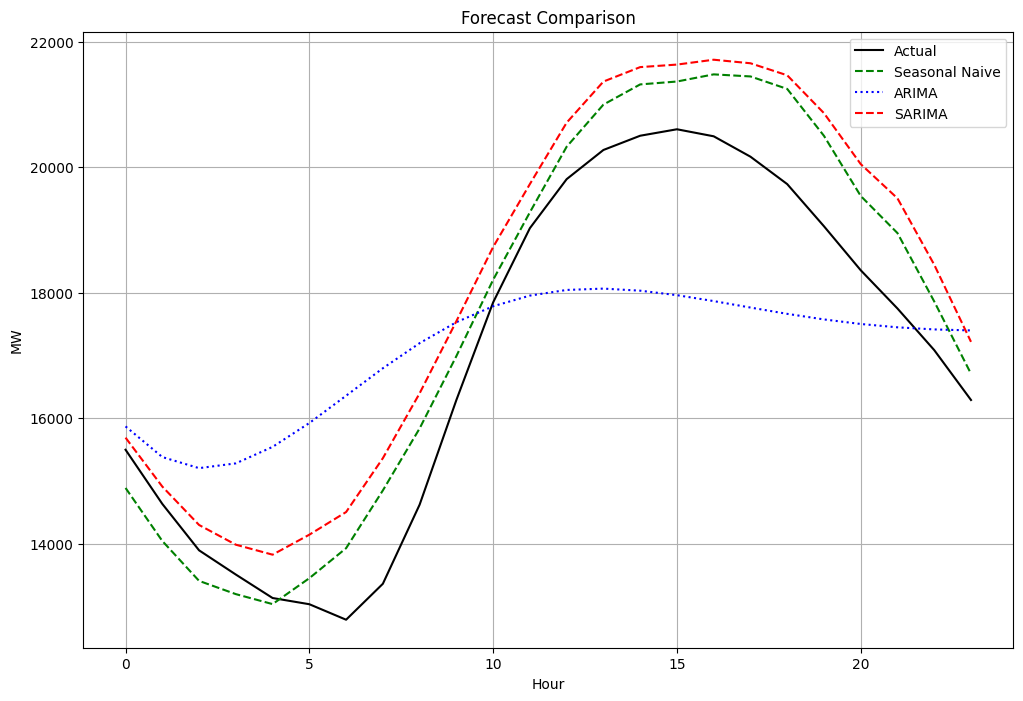

In [12]:
print("\n=== Forecast Visualization ===")

plt.figure(figsize=(12, 8))

plt.plot(range(24), test_actual, 'k-', label='Actual')
plt.plot(range(24), seasonal_naive_forecast, 'g--', label='Seasonal Naive')
plt.plot(range(24), arima_forecast_values, 'b:', label='ARIMA')

if 'sarima_forecast_values' in locals():
  plt.plot(range(24), sarima_forecast_values, 'r--', label='SARIMA')

plt.title('Forecast Comparison')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.legend()
plt.grid()
plt.show()

12. Residual Analysis


=== Error Analysis ===


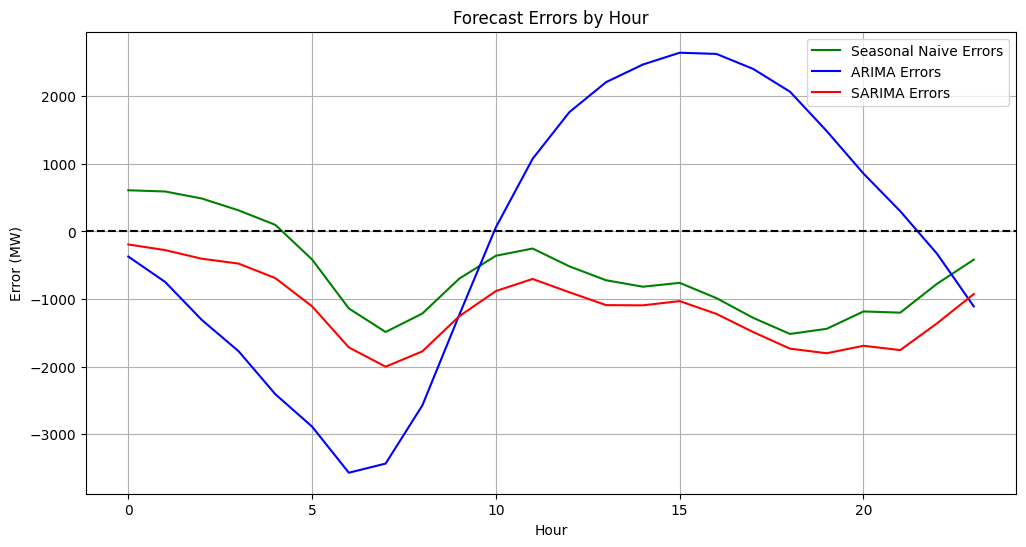

In [13]:
print("\n=== Error Analysis ===")

# Calculate errors
seasonal_naive_errors = test_actual - seasonal_naive_forecast
arima_errors = test_actual - arima_forecast_values

# Plot errors
plt.figure(figsize=(12, 6))

plt.plot(range(24), seasonal_naive_errors, 'g-', label='Seasonal Naive Errors')
plt.plot(range(24), arima_errors, 'b-', label='ARIMA Errors')

if 'sarima_forecast_values' in locals():
   sarima_errors = test_actual - sarima_forecast_values
   plt.plot(range(24), sarima_errors, 'r-', label='SARIMA Errors')

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Forecast Errors by Hour')
plt.xlabel('Hour')
plt.ylabel('Error (MW)')
plt.legend()
plt.grid(True)
plt.show()